In [2]:
import pandas as pd
import numpy as np

In [3]:
# Import dataset again
df = pd.read_csv('dataset.csv')

df.head()

/var/folders/rr/_jml0ccd2x9br7wz_c92rsbc0000gn/T/ipykernel_45032/1885297019.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset.csv')


,Car_Id,Person_Id,Trip,GPS_Time,Device_Time,GPS_Long,GPS_Lat,GPS_Speed_Ms,GPS_HDOP,GPS_Bearing,...,OBD_CO2_gkm_Instant,Device_Cost_Km_Inst,Device_Cost_Km_Trip,OBD_Air_Pedal,Context,Acceleration_kmhs,Reaction_Time,Air_Drag_Force,Speed_RPM_Relation,KPL_Instant
0,1,1,1,0,02-Sep-2016 09:00:39.858,0.0,0.0,0.0,0,0.0,...,66.32,0.11,0.19,14.51,0,-1,2.777778,77.810185,0.022841,39.07
1,1,1,1,0,02-Sep-2016 09:00:40.858,0.0,0.0,0.0,0,0.0,...,69.98,0.03,0.18,14.12,0,-2,1.388889,71.587963,0.023264,37.00
2,1,1,1,0,02-Sep-2016 09:00:41.856,0.0,0.0,0.0,0,0.0,...,70.83,0.03,0.18,13.33,0,-4,0.694444,59.921296,0.026675,37.35
3,1,1,1,0,02-Sep-2016 09:00:42.860,0.0,0.0,0.0,0,0.0,...,63.39,0.03,0.18,14.51,0,-11,0.252525,33.185185,0.023594,36.08
4,1,1,1,0,02-Sep-2016 09:00:43.863,0.0,0.0,0.0,0,0.0,...,141.04,0.03,0.18,14.51,0,-4,0.694444,25.407407,0.022351,18.11


In [4]:
# df.Context.unique() # Context means Urban, Highway, etc. but only 1 value "Urban" exists
print(df.GPS_Time.unique())

[0 '0' 'Fri Oct 14 17:04:47 GMT-03:00 2016' ...
 'Sun Sep 18 15:12:06 BRT 2016' 'Sun Sep 18 15:12:07 BRT 2016'
 'Sun Sep 18 15:12:08 BRT 2016']


In [5]:
# Drop unecessary columns
df_feature_selection = df.drop(columns=["Reaction_Time", "GPS_Time", "Device_Time"])

df_feature_selection.columns

Index(['Car_Id', 'Person_Id', 'Trip', 'GPS_Long', 'GPS_Lat', 'GPS_Speed_Ms',
       'GPS_HDOP', 'GPS_Bearing', 'Gx', 'Gy', 'Gz', 'G_Calibrated',
       'OBD_KPL_Average', 'OBD_Trip_KPL_Average', 'OBD_Intake_Air_Temp_C',
       'Device_Barometer_M', 'GPS_Altitude_M', 'OBD_Engine_Load',
       'OBD_Fuel_Level', 'GPS_Accuracy_M', 'OBD_Speed_Km', 'GPS_Speed_Km',
       'Device_Trip_Dist_Km', 'OBD_Engine_Coolant_Temp_C', 'OBD_Engine_RPM',
       'OBD_Adapter_Voltage', 'OBD_KPL_Instant', 'OBD_Fuel_Flow_CCmin',
       'Device_Fuel_Remaining', 'OBD_Ambient_Air_Temp_C',
       'OBD_CO2_gkm_Average', 'OBD_CO2_gkm_Instant', 'Device_Cost_Km_Inst',
       'Device_Cost_Km_Trip', 'OBD_Air_Pedal', 'Context', 'Acceleration_kmhs',
       'Air_Drag_Force', 'Speed_RPM_Relation', 'KPL_Instant'],
      dtype='object')

In [6]:
# Clean data: handle all non-numeric characters properly
df_cleaned = df_feature_selection.copy()

print("Cleaning data...")
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object':
        # Convert to string first
        df_cleaned[col] = df_cleaned[col].astype(str)
        
        # Replace common infinity and invalid representations
        df_cleaned[col] = df_cleaned[col].replace(['∞', 'inf', '-inf', 'nan', 'ﾃ??', 'null', 'NULL'], np.nan)
        
        # Try to convert to numeric, setting errors to NaN
        numeric_col = pd.to_numeric(df_cleaned[col], errors='coerce')
        
        # Check if conversion was successful (i.e., mostly numeric values)
        if numeric_col.notna().sum() > len(df_cleaned) * 0.5:  # More than 50% convertible
            df_cleaned[col] = numeric_col
            print(f"  Converted {col} to numeric")
        else:
            print(f"  Kept {col} as categorical (non-numeric)")

# Handle NaN values in numeric columns - fill with median
for col in df_cleaned.select_dtypes(include=[np.number]).columns:
    if df_cleaned[col].isna().any():
        nan_count = df_cleaned[col].isna().sum()
        median_val = df_cleaned[col].median()
        df_cleaned[col].fillna(median_val, inplace=True)
        print(f"  Filled {nan_count} NaN values in {col} with median: {median_val}")

# Create X and y from cleaned data
X = df_cleaned.drop(columns=["OBD_CO2_gkm_Instant"])
y = pd.Series(df_cleaned["OBD_CO2_gkm_Instant"])

# Update categorical and numerical column lists
cat_col = ['Car_Id', 'Person_Id', 'Trip', 'Context']
num_col = [col for col in X.columns if col not in cat_col and X[col].dtype in ['int64', 'float64']]

print(f"\nFinal column counts:")
print(f"  Categorical columns: {len(cat_col)}")
print(f"  Numerical columns: {len(num_col)}")
print(f"  Total columns in X: {len(X.columns)}")

Cleaning data...
  Converted Device_Cost_Km_Inst to numeric
  Filled 7370 NaN values in Device_Cost_Km_Inst with median: 0.14

Final column counts:
  Categorical columns: 4
  Numerical columns: 35
  Total columns in X: 39


/var/folders/rr/_jml0ccd2x9br7wz_c92rsbc0000gn/T/ipykernel_45032/648675704.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(median_val, inplace=True)


In [7]:
# More thorough check of object columns
print("Checking all object-type columns for non-numeric data:")
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"\nColumn {col}:")
        # Check for various non-numeric patterns
        sample_values = X[col].dropna().head(10)
        print(f"  Sample values: {list(sample_values)}")
        
        # Try to convert to numeric and see what fails
        try:
            pd.to_numeric(X[col], errors='raise')
            print(f"  Can be converted to numeric")
        except:
            # Find non-numeric values
            non_numeric = []
            for val in X[col].dropna().unique():
                try:
                    float(val)
                except:
                    non_numeric.append(val)
            print(f"  Non-numeric values found: {non_numeric[:10]} ({'...' if len(non_numeric) > 10 else ''})")  

Checking all object-type columns for non-numeric data:


In [8]:
with pd.option_context('display.max_columns', None, 'display.width', 2000):
    print(X.describe())

             Car_Id     Person_Id         Trip      GPS_Long       GPS_Lat  GPS_Speed_Ms      GPS_HDOP    GPS_Bearing            Gx            Gy            Gz  G_Calibrated  OBD_KPL_Average  OBD_Trip_KPL_Average  OBD_Intake_Air_Temp_C  Device_Barometer_M  GPS_Altitude_M  OBD_Engine_Load  OBD_Fuel_Level  GPS_Accuracy_M  OBD_Speed_Km  GPS_Speed_Km  Device_Trip_Dist_Km  OBD_Engine_Coolant_Temp_C  OBD_Engine_RPM  OBD_Adapter_Voltage  OBD_KPL_Instant  OBD_Fuel_Flow_CCmin  Device_Fuel_Remaining  OBD_Ambient_Air_Temp_C  OBD_CO2_gkm_Average  Device_Cost_Km_Inst  Device_Cost_Km_Trip  OBD_Air_Pedal  Context  Acceleration_kmhs  Air_Drag_Force  Speed_RPM_Relation   KPL_Instant
count  91794.000000  91794.000000  91794.00000  91794.000000  91794.000000  91794.000000  91794.000000   91794.000000  91794.000000  91794.000000  91794.000000  91794.000000     91794.000000          91794.000000           91794.000000        91794.000000    91794.000000     91794.000000    91794.000000    91794.000000  917

In [9]:
# Preprocessing Mixed Data - moved here to use updated num_col
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Define preprocessor after X is created and num_col is updated
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(), cat_col)
    ]
)

In [10]:
# X_preprocessed = preprocessor.fit_transform(X)

# #Turn X_preprocessed back to DataFrame for easier handling
# ohe = preprocessor.named_transformers_['cat']
# ohe_feature_names = ohe.get_feature_names_out(cat_col)
# all_feature_names = np.concatenate([num_col, ohe_feature_names])
# X_preprocessed = pd.DataFrame(X_preprocessed, columns=all_feature_names)
# X_preprocessed.head()

In [11]:
# from sklearn.ensemble import RandomForestRegressor
# random_forest = RandomForestRegressor(n_estimators=100, random_state = 42, n_jobs=-1)
# random_forest.fit(X_preprocessed, y)


In [12]:
# importances = pd.Series(random_forest.feature_importances_, index=X_preprocessed.columns)
# importances = importances.sort_values(ascending=False)

# print("Feature Importances:\n", importances)

# # Optionally select top N features
# top_features = importances.head(5).index.tolist()
# print("\nTop 5 important features:", top_features)

In [13]:
# Using RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

forest = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])




In [14]:
# Fit the pipeline
forest.fit(X, y)

# Get feature importances from the fitted regressor
importances_values = forest.named_steps['regressor'].feature_importances_

# Reconstruct the feature names after preprocessing:
# - numeric columns are num_col
# - categorical columns were one-hot encoded by the preprocessor's 'cat' transformer
ohe = forest.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_col)

# Combine numeric + OHE feature names to match the transformed feature vector
all_feature_names = np.concatenate([num_col, ohe_feature_names])

# Debug: Check lengths
print(f"Length of importances_values: {len(importances_values)}")
print(f"Length of all_feature_names: {len(all_feature_names)}")
print(f"Length of num_col: {len(num_col)}")
print(f"Length of ohe_feature_names: {len(ohe_feature_names)}")
print(f"Length of cat_col: {len(cat_col)}")

# Check if lengths match before creating Series
if len(importances_values) == len(all_feature_names):
    # Create the Series with correct index and sort
    importances = pd.Series(importances_values, index=all_feature_names)
    importances = importances.sort_values(ascending=False)
    
    # Show top importances (optional)
    print("\nTop 20 feature importances:")
    print(importances.head(20))
else:
    print(f"\nERROR: Length mismatch!")
    print(f"Expected {len(importances_values)} features, got {len(all_feature_names)} feature names")
    
    # Let's investigate further
    print(f"\nNum_col contents: {num_col}")
    print(f"\nCat_col contents: {cat_col}")
    print(f"\nOHE feature names: {list(ohe_feature_names)}")



Length of importances_values: 63
Length of all_feature_names: 63
Length of num_col: 35
Length of ohe_feature_names: 28
Length of cat_col: 4

Top 20 feature importances:
OBD_KPL_Instant          0.439821
OBD_Fuel_Flow_CCmin      0.407999
KPL_Instant              0.046354
Air_Drag_Force           0.046198
OBD_Speed_Km             0.039476
Acceleration_kmhs        0.006098
Speed_RPM_Relation       0.001868
GPS_Speed_Ms             0.001031
OBD_Engine_RPM           0.000843
Gx                       0.000809
Device_Cost_Km_Inst      0.000740
OBD_Engine_Load          0.000673
Device_Trip_Dist_Km      0.000606
OBD_Trip_KPL_Average     0.000508
GPS_Long                 0.000489
GPS_Speed_Km             0.000469
OBD_Air_Pedal            0.000453
Gz                       0.000401
OBD_CO2_gkm_Average      0.000376
Device_Fuel_Remaining    0.000376
dtype: float64


## Using LASSO

In [15]:
# Use LASSO for feature selection
from sklearn.linear_model import LassoCV

lasso = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lassoRegressor", LassoCV(cv=5, random_state=42))
])

lasso.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GPS_Long', 'GPS_Lat',
                                                   'GPS_Speed_Ms', 'GPS_HDOP',
                                                   'GPS_Bearing', 'Gx', 'Gy',
                                                   'Gz', 'G_Calibrated',
                                                   'OBD_KPL_Average',
                                                   'OBD_Trip_KPL_Average',
                                                   'OBD_Intake_Air_Temp_C',
                                                   'Device_Barometer_M',
                                                   'GPS_Altitude_M',
                                                   'OBD_Engine_Load',
                                                   'OBD_Fuel_Level',
                                                   'GPS_Accuracy_M',
                                                   'OBD_Speed_Km',...
                                                   'Device_Trip_Dist_Km',
                                                   'OBD_Engine_Coolant_Temp_C',
                                                   'OBD_Engine_RPM',
                                                   'OBD_Adapter_Voltage',
                                                   'OBD_KPL_Instant',
                                                   'OBD_Fuel_Flow_CCmin',
                                                   'Device_Fuel_Remaining',
                                                   'OBD_Ambient_Air_Temp_C',
                                                   'OBD_CO2_gkm_Average',
                                                   'Device_Cost_Km_Inst',
                                                   'Device_Cost_Km_Trip', ...]),
                                                 ('cat', OneHotEncoder(),
                                                  ['Car_Id', 'Person_Id',
                                                   'Trip', 'Context'])])),
                ('lassoRegressor', LassoCV(cv=5, random_state=42))])

In [16]:
import numpy as np

# Reconstruct feature names that correspond to the transformed feature vector
# (numeric features + one-hot encoded categorical features) and use them as index.
try:
    ohe = lasso.named_steps['preprocessor'].named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(cat_col)
    feature_names = np.concatenate([num_col, ohe_feature_names])
except Exception:
    # fallback if reconstruction fails (use precomputed all_feature_names)
    feature_names = all_feature_names

# Get LASSO coefficients
lasso_coef = lasso.named_steps['lassoRegressor'].coef_

# Create coefficient series with feature names
coef = pd.Series(lasso_coef, index=feature_names)

# Select features with non-zero coefficients
selected_features = coef[coef != 0]

# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)
np.set_printoptions(threshold=np.inf)

print(f"Number of selected features (non-zero coefficients): {len(selected_features)}")
print("Selected features:", selected_features.index.tolist())
print("\nLASSO coefficients (non-zero only):")
print(selected_features.sort_values(ascending=False))
print(f"\nOptimal alpha (λ): {lasso.named_steps['lassoRegressor'].alpha_:.4f}")

if len(selected_features) == 0:
    print("\nWarning: LASSO selected no features. Alpha might be too high.")
    print("All coefficients:")
    print(coef.sort_values(ascending=False))

Number of selected features (non-zero coefficients): 35
Selected features: ['GPS_Speed_Ms', 'GPS_HDOP', 'GPS_Bearing', 'Gx', 'Gz', 'G_Calibrated', 'OBD_Trip_KPL_Average', 'OBD_Intake_Air_Temp_C', 'Device_Barometer_M', 'GPS_Altitude_M', 'OBD_Engine_Load', 'OBD_Speed_Km', 'GPS_Speed_Km', 'Device_Trip_Dist_Km', 'OBD_Engine_Coolant_Temp_C', 'OBD_Engine_RPM', 'OBD_Adapter_Voltage', 'OBD_Fuel_Flow_CCmin', 'Device_Fuel_Remaining', 'OBD_CO2_gkm_Average', 'Device_Cost_Km_Inst', 'OBD_Air_Pedal', 'Acceleration_kmhs', 'Air_Drag_Force', 'Speed_RPM_Relation', 'KPL_Instant', 'Person_Id_1', 'Person_Id_3', 'Trip_2', 'Trip_3', 'Trip_4', 'Trip_5', 'Trip_9', 'Trip_11', 'Trip_15']

LASSO coefficients (non-zero only):
OBD_Fuel_Flow_CCmin          146.330554
OBD_Engine_RPM               108.122869
Speed_RPM_Relation            62.826411
KPL_Instant                   51.110925
OBD_Engine_Load               34.779793
Acceleration_kmhs              8.748349
OBD_CO2_gkm_Average            8.156429
Trip_2        

## Fuel Efficiency

In [17]:
# Add new column "Fuel_Consumed_L" in df_cleaned
df_cleaned['Fuel_Consumed_L'] = df_cleaned['Device_Trip_Dist_Km'] / df_cleaned['OBD_KPL_Instant']

In [18]:
# Create X and y from cleaned data
X = df_cleaned.drop(columns=["Fuel_Consumed_L"])
y = pd.Series(df_cleaned["Fuel_Consumed_L"])

# Update categorical and numerical column lists
cat_col = ['Car_Id', 'Person_Id', 'Trip', 'Context']
num_col = [col for col in X.columns if col not in cat_col and X[col].dtype in ['int64', 'float64']]

# Change y if it has inf
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# Change nan to median
y.fillna(y.median(), inplace=True)

print(f"Updated column counts for fuel consumption prediction:")
print(f"  Categorical columns: {len(cat_col)}")
print(f"  Numerical columns: {len(num_col)}")
print(f"  Total columns in X: {len(X.columns)}")

# Update preprocessor for the new feature set
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_fuel = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(), cat_col)
    ]
)

Updated column counts for fuel consumption prediction:
  Categorical columns: 4
  Numerical columns: 36
  Total columns in X: 40


In [19]:
# Create a new forest pipeline for fuel consumption prediction
forest_fuel = Pipeline(steps=[
    ("preprocessor", preprocessor_fuel),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

forest_fuel.fit(X, y)

# Get feature importances from the fitted regressor
importances_values = forest_fuel.named_steps['regressor'].feature_importances_

# Reconstruct the feature names after preprocessing:
# - numeric columns are num_col
# - categorical columns were one-hot encoded by the preprocessor's 'cat' transformer
ohe = forest_fuel.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_col)

# Combine numeric + OHE feature names to match the transformed feature vector
all_feature_names = np.concatenate([num_col, ohe_feature_names])

# Debug: Check lengths
print(f"Length of importances_values: {len(importances_values)}")
print(f"Length of all_feature_names: {len(all_feature_names)}")

# Create the Series with correct index and sort
importances = pd.Series(importances_values, index=all_feature_names)
importances = importances.sort_values(ascending=False)

# Show top importances (optional)
importances.head(20)

Length of importances_values: 64
Length of all_feature_names: 64


OBD_KPL_Instant          0.513746
Device_Trip_Dist_Km      0.345125
KPL_Instant              0.052795
Device_Cost_Km_Inst      0.043337
OBD_Fuel_Flow_CCmin      0.009621
Device_Barometer_M       0.004027
OBD_Engine_Load          0.003707
OBD_Air_Pedal            0.003006
G_Calibrated             0.002119
Speed_RPM_Relation       0.002094
Device_Fuel_Remaining    0.001919
Acceleration_kmhs        0.001743
OBD_CO2_gkm_Instant      0.001568
Air_Drag_Force           0.001475
OBD_Speed_Km             0.001410
Gy                       0.001272
OBD_Engine_RPM           0.001231
OBD_Trip_KPL_Average     0.001181
OBD_KPL_Average          0.001158
OBD_CO2_gkm_Average      0.000806
dtype: float64

## OBD_Adapter_Voltage

In [20]:
# Create X and y from cleaned data
X = df_cleaned.drop(columns=["OBD_Adapter_Voltage"])
y = pd.Series(df_cleaned["OBD_Adapter_Voltage"])

# Update categorical and numerical column lists
cat_col = ['Car_Id', 'Person_Id', 'Trip', 'Context']
num_col = [col for col in X.columns if col not in cat_col and X[col].dtype in ['int64', 'float64']]

# Change y if it has inf
y.replace([np.inf, -np.inf], np.nan, inplace=True)

# Change nan to median
y.fillna(y.median(), inplace=True)

print(f"Updated column counts for fuel consumption prediction:")
print(f"  Categorical columns: {len(cat_col)}")
print(f"  Numerical columns: {len(num_col)}")
print(f"  Total columns in X: {len(X.columns)}")

# Update preprocessor for the new feature set
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor_fuel = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_col),
        ('cat', OneHotEncoder(), cat_col)
    ]
)

Updated column counts for fuel consumption prediction:
  Categorical columns: 4
  Numerical columns: 36
  Total columns in X: 40


In [21]:
# Create a new forest pipeline for fuel consumption prediction
forest_fuel = Pipeline(steps=[
    ("preprocessor", preprocessor_fuel),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

forest_fuel.fit(X, y)

# Get feature importances from the fitted regressor
importances_values = forest_fuel.named_steps['regressor'].feature_importances_

# Reconstruct the feature names after preprocessing:
# - numeric columns are num_col
# - categorical columns were one-hot encoded by the preprocessor's 'cat' transformer
ohe = forest_fuel.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(cat_col)

# Combine numeric + OHE feature names to match the transformed feature vector
all_feature_names = np.concatenate([num_col, ohe_feature_names])

# Debug: Check lengths
print(f"Length of importances_values: {len(importances_values)}")
print(f"Length of all_feature_names: {len(all_feature_names)}")

# Create the Series with correct index and sort
importances = pd.Series(importances_values, index=all_feature_names)
importances = importances.sort_values(ascending=False)

# Show top importances (optional)
importances.head(20)

Length of importances_values: 64
Length of all_feature_names: 64


OBD_KPL_Average              0.305911
OBD_Intake_Air_Temp_C        0.172695
OBD_CO2_gkm_Average          0.063538
Device_Trip_Dist_Km          0.044593
Device_Fuel_Remaining        0.042670
OBD_Engine_RPM               0.036404
Air_Drag_Force               0.029205
OBD_Trip_KPL_Average         0.027529
OBD_Speed_Km                 0.027397
Trip_4                       0.027366
Device_Barometer_M           0.019011
OBD_Engine_Coolant_Temp_C    0.016450
GPS_Lat                      0.015944
OBD_KPL_Instant              0.014525
OBD_Fuel_Flow_CCmin          0.013982
Person_Id_1                  0.013833
Person_Id_10                 0.011904
Fuel_Consumed_L              0.011277
GPS_Long                     0.009822
Speed_RPM_Relation           0.009773
dtype: float64

## Cross Validation for PCA

In [22]:
df_cleaned.head()

df_cleaned.columns

Index(['Car_Id', 'Person_Id', 'Trip', 'GPS_Long', 'GPS_Lat', 'GPS_Speed_Ms', 'GPS_HDOP', 'GPS_Bearing', 'Gx', 'Gy', 'Gz', 'G_Calibrated', 'OBD_KPL_Average', 'OBD_Trip_KPL_Average', 'OBD_Intake_Air_Temp_C', 'Device_Barometer_M', 'GPS_Altitude_M', 'OBD_Engine_Load', 'OBD_Fuel_Level', 'GPS_Accuracy_M', 'OBD_Speed_Km', 'GPS_Speed_Km', 'Device_Trip_Dist_Km', 'OBD_Engine_Coolant_Temp_C', 'OBD_Engine_RPM', 'OBD_Adapter_Voltage', 'OBD_KPL_Instant', 'OBD_Fuel_Flow_CCmin', 'Device_Fuel_Remaining', 'OBD_Ambient_Air_Temp_C', 'OBD_CO2_gkm_Average', 'OBD_CO2_gkm_Instant', 'Device_Cost_Km_Inst', 'Device_Cost_Km_Trip', 'OBD_Air_Pedal', 'Context', 'Acceleration_kmhs', 'Air_Drag_Force', 'Speed_RPM_Relation', 'KPL_Instant', 'Fuel_Consumed_L'], dtype='object')

In [23]:
# X and y for CO2_Instant
X = df_cleaned.drop(columns=["OBD_CO2_gkm_Instant"])
y = pd.Series(df_cleaned["OBD_CO2_gkm_Instant"])

In [24]:
# Using PCA with Cross-Validation
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

In [25]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Score with 1 PCA components: 139976.51480808915


Score with 2 PCA components: 128938.92513836456
Score with 3 PCA components: 154909.51769227846
Score with 4 PCA components: 678542.2694407401
Score with 5 PCA components: 208850.11797357677
Score with 6 PCA components: 965692.3555212477
Score with 7 PCA components: 230062.50348973894
Score with 8 PCA components: 380686.3822353475
Score with 9 PCA components: 359431.84971933166
Score with 10 PCA components: 360365.3675701704
Score with 11 PCA components: 1350595.0529662324
Score with 12 PCA components: 183736.97617234732
Score with 13 PCA components: 987047.4317114
Score with 14 PCA components: 861127.767472808
Score with 15 PCA components: 664298.365941259
Score with 16 PCA components: 379055.4688896594
Score with 17 PCA components: 427666.6469956279
Score with 18 PCA components: 238120.5439816013
Score with 19 PCA components: 251144.49607739504


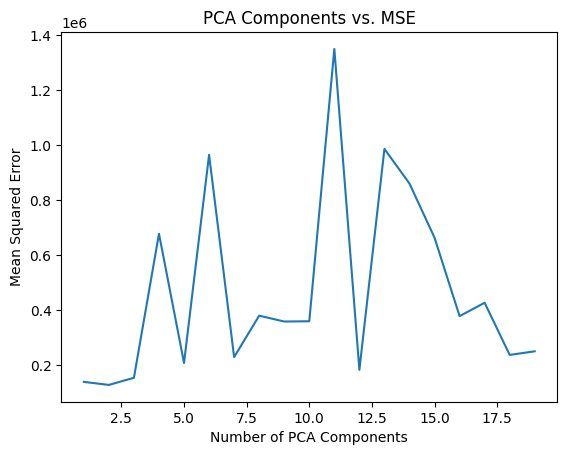

In [26]:
# Regression with PCA components
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()

# Check score on different number of pca components
pca_scores = []
for i in range(1, 20):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    print(f"Score with {i} PCA components: {score}")
    # Save in a list for visualization later
    pca_scores.append(score)

# Visualize PCA scores
import matplotlib.pyplot as plt
plt.plot(range(1, 20), pca_scores)
plt.xlabel('Number of PCA Components')
plt.ylabel('Mean Squared Error')
plt.title('PCA Components vs. MSE')
plt.show()


In [27]:
# Data Validation 
top_columns = ["OBD_KPL_Instant", "OBD_Fuel_Flow_CCmin", "KPL_Instant", "Air_Drag_Force", "OBD_Speed_Km", "Acceleration_kmhs", "Speed_RPM_Relation", "OBD_Engine_RPM", "GPS_Speed_Ms", "Gx", "Device_Cost_Km_Inst", "OBD_Engine_Load", "Device_Trip_Dist_Km", "GPS_Speed_Km", "GPS_Long", "OBD_Air_Pedal", "OBD_Trip_KPL_Average", "GPS_Bearing", "G_Calibrated", "Gz"]

Score after adding column OBD_KPL_Instant: 63273.216946582674
Score after adding column OBD_Fuel_Flow_CCmin: 42419.80507608639
Score after adding column KPL_Instant: 42440.66562805267
Score after adding column Air_Drag_Force: 23878.927774152027
Score after adding column OBD_Speed_Km: 26088.05279851551
Score after adding column Acceleration_kmhs: 26015.309652192296
Score after adding column Speed_RPM_Relation: 26047.17023433216
Score after adding column OBD_Engine_RPM: 25477.71051523032
Score after adding column GPS_Speed_Ms: 25470.78708144001
Score after adding column Gx: 25465.31347574788
Score after adding column Device_Cost_Km_Inst: 25366.990436221204
Score after adding column OBD_Engine_Load: 33959.063241661155
Score after adding column Device_Trip_Dist_Km: 33887.994248000046
Score after adding column GPS_Speed_Km: 40380.73108360338
Score after adding column GPS_Long: 43846.7062579253
Score after adding column OBD_Air_Pedal: 43640.96633486018
Score after adding column OBD_Trip_KPL_

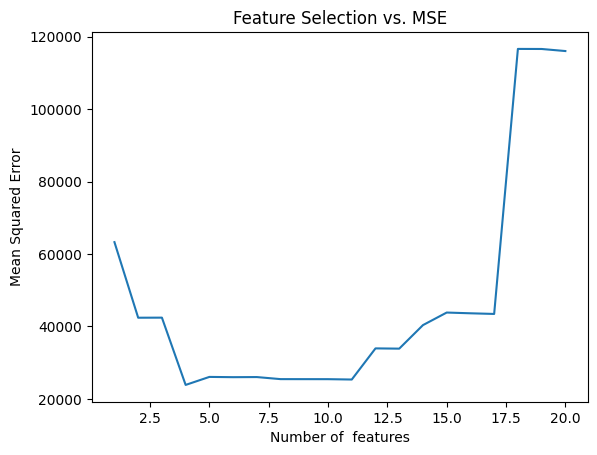

In [28]:
X_col = []
pca_scores = []
for col in top_columns:
    X_col.append(col)
    X = df_cleaned.loc[:, X_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    print(f"Score after adding column {col}: {score}")

    # Save in a list for visualization later
    pca_scores.append(score)

# Visualize PCA scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca_scores) + 1), pca_scores)
plt.xlabel('Number of  features')
plt.ylabel('Mean Squared Error')
plt.title('Feature Selection vs. MSE')
plt.show()


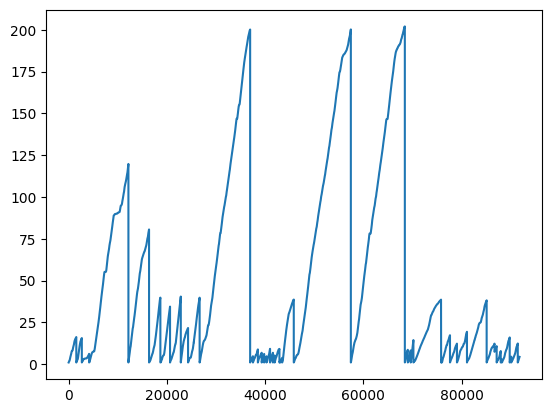

In [39]:
# Find Grade column
from matplotlib import pyplot as plt

plt.plot(df.index, df['Device_Trip_Dist_Km'])


In [50]:
# Check which row is start of new trip
# List the columns that define a unique entity
identifier_columns = ['Car_Id', 'Person_Id', 'Trip']

# Use drop_duplicates() and keep=False to find only the rows 
# that are unique across ALL specified columns.
# Leaving keep='first' (the default) will give you the first instance of each unique combination.
unique_combinations = df[identifier_columns].drop_duplicates()

print("Number of unique Car-Person-Trip combinations:", len(unique_combinations))
print("\nFirst 5 unique combinations:")
print(unique_combinations.index.tolist())


Number of unique Car-Person-Trip combinations: 44

First 5 unique combinations:
[0, 1560, 2685, 4171, 12169, 16370, 18675, 20643, 22832, 24312, 26664, 36949, 37519, 38522, 39300, 39301, 39801, 40268, 41006, 41591, 41937, 42914, 43056, 43462, 45831, 57449, 68441, 69049, 69634, 70184, 75810, 75828, 75956, 77632, 79050, 81089, 85095, 86698, 87133, 87964, 88174, 89789, 90101, 91431]


In [ ]:

df['Delta_Altitude_M'] = df['GPS_Altitude_M'].diff()
df['Delta_Altitude_M'].iloc[unique_combinations.index.tolist()] = 0


df['Delta_Distance_M'] = df['Device_Trip_Dist_Km'].diff()*1000 # Change to meters
df['Delta_Distance_M'].iloc[unique_combinations.index.tolist()] = 0

# Avoid division by zero and filter out noise when stationary (minimum 1 meter traveled)
moving_mask = df['Delta_Distance_M'].abs() >= 1

# 3. Calculate Grade for moving segments: (Rise / Run) * 100
df.loc[moving_mask, 'Road_Grade_Percent'] = (
    (df['Delta_Altitude_M'] / df['Delta_Distance_M']) * 100
)

# Set grade to 0 when the vehicle is stationary or for the first point
df.loc[~moving_mask, 'Road_Grade_Percent'] = 0
df.loc[df.index[unique_combinations.index.tolist()], 'Road_Grade_Percent'] = 0 # First row is NaN
df[df['Road_Grade_Percent']>1000] = 0



/var/folders/rr/_jml0ccd2x9br7wz_c92rsbc0000gn/T/ipykernel_45032/2413358021.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Delta_Altitude_M'].iloc[unique_combinations.index.tolist()] = 0
/var/folders/rr/_jml0ccd2x9br7wz_c92rsbc0000g

0

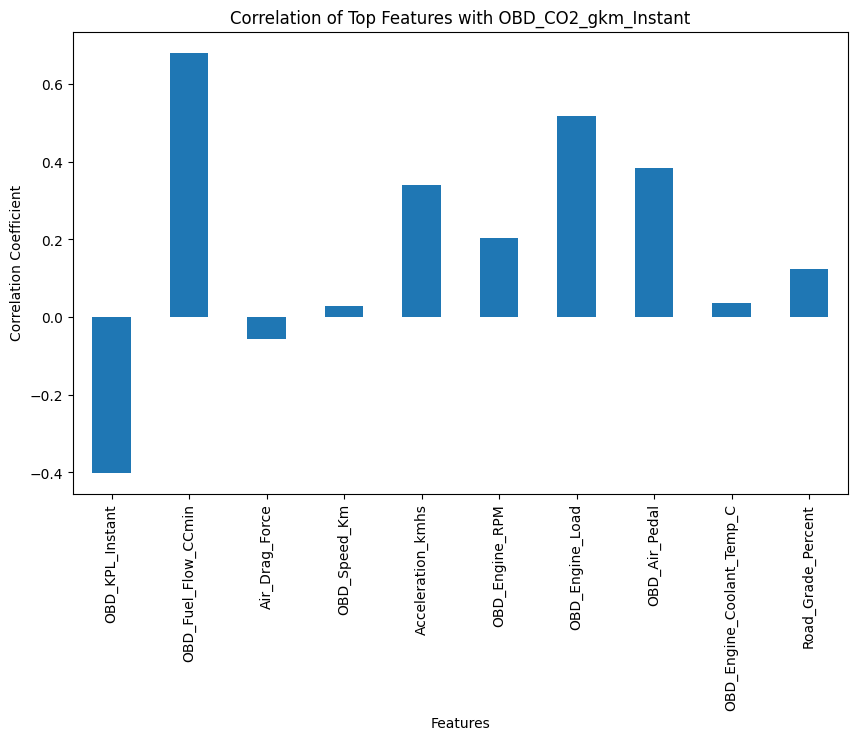

In [ ]:
## Correlation of top features to CO2_Instant
top_features = ["OBD_KPL_Instant", "OBD_Fuel_Flow_CCmin", "Air_Drag_Force", "OBD_Speed_Km", "Acceleration_kmhs", "OBD_Engine_RPM", "OBD_Engine_Load", "OBD_Air_Pedal", "OBD_Engine_Coolant_Temp_C","Road_Grade_Percent"]

correlations = df[top_features + ["OBD_CO2_gkm_Instant"]].corr()
correlation_with_co2 = correlations["OBD_CO2_gkm_Instant"].drop("OBD_CO2_gkm_Instant")

# Visualize correlations
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
correlation_with_co2.plot(kind='bar')
plt.title('Correlation of Top Features with OBD_CO2_gkm_Instant')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


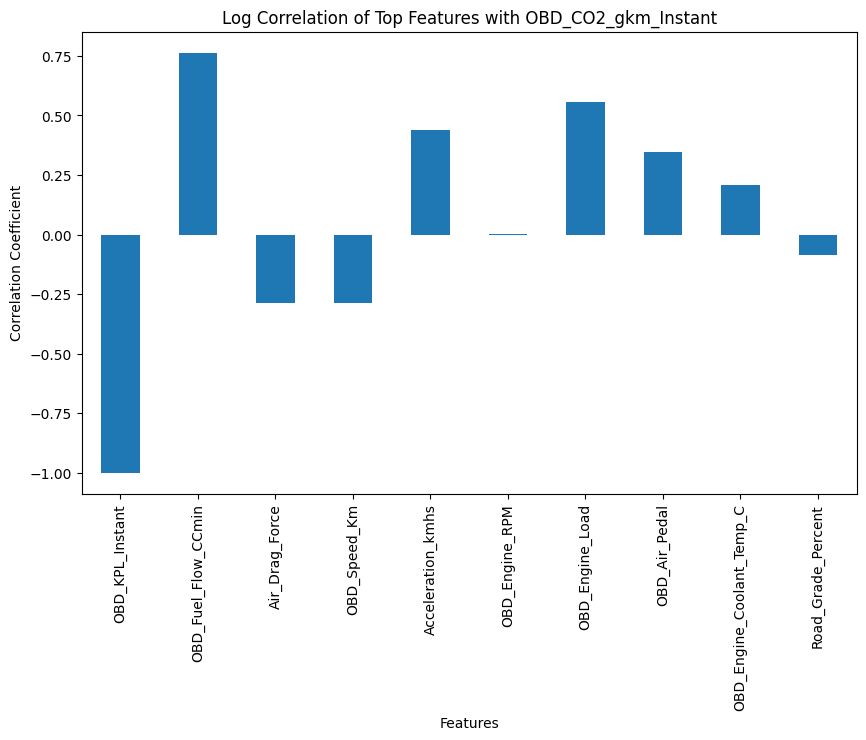

In [76]:
# Check log correlations
log_df = df[top_features + ["OBD_CO2_gkm_Instant"]].copy()
for col in log_df.columns:
    log_df[col] = log_df[col].apply(lambda x: np.log(x) if x > 0 else np.nan)
log_correlations = log_df.corr()
log_correlation_with_co2 = log_correlations["OBD_CO2_gkm_Instant"].drop("OBD_CO2_gkm_Instant")    
# Visualize log correlations
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
log_correlation_with_co2.plot(kind='bar')
plt.title('Log Correlation of Top Features with OBD_CO2_gkm_Instant')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()

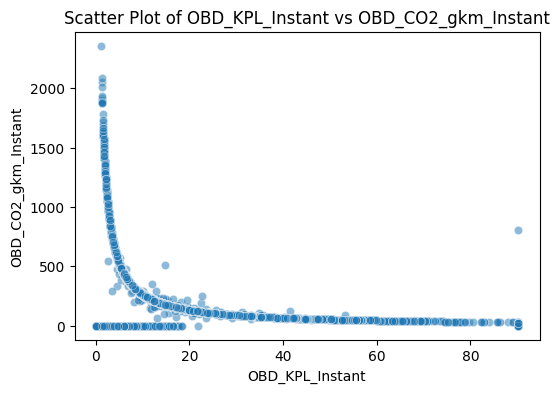

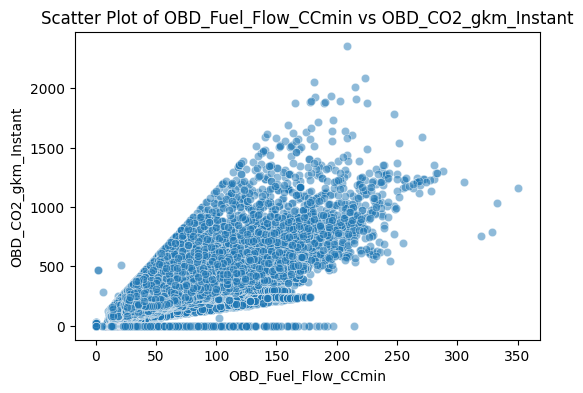

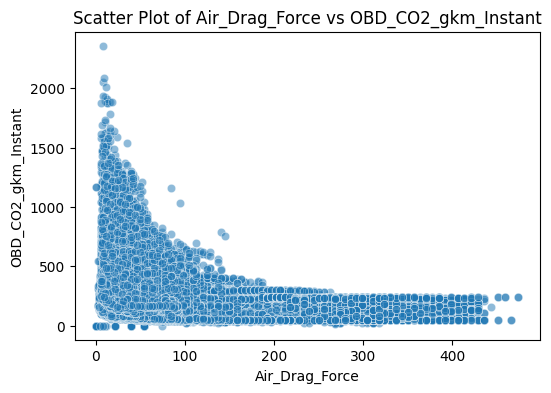

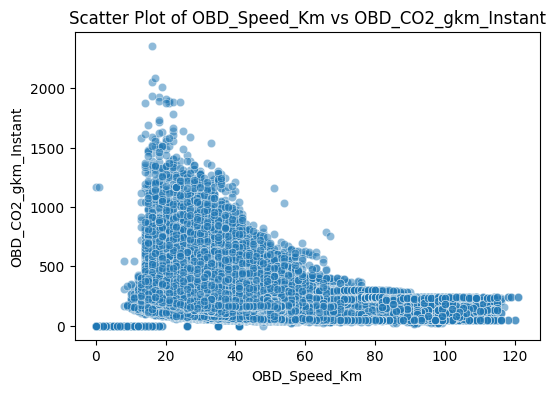

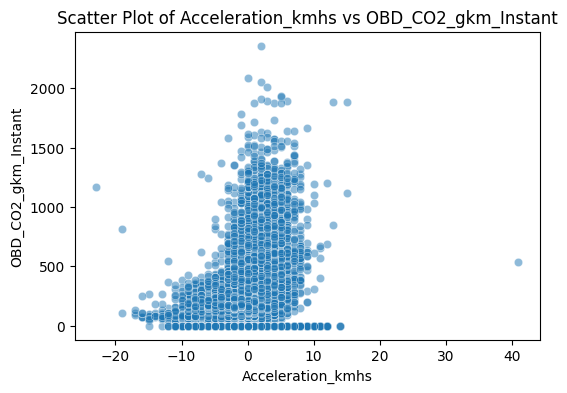

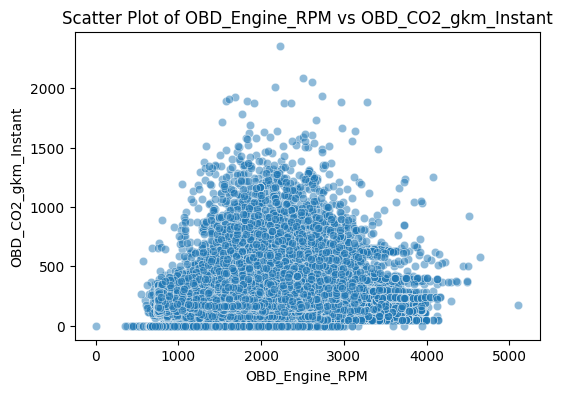

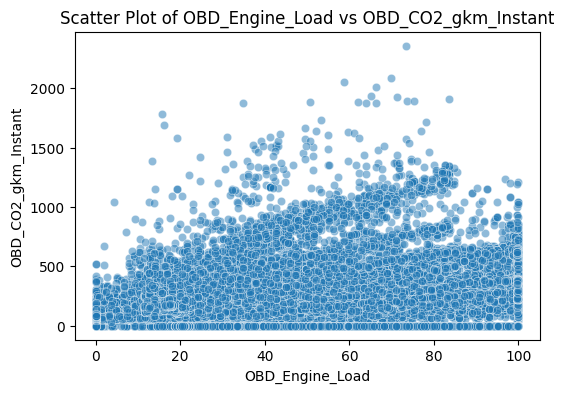

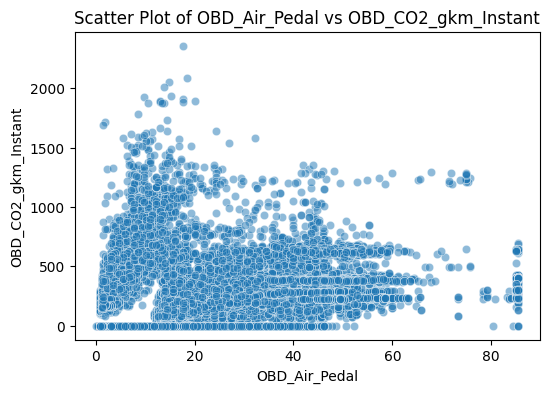

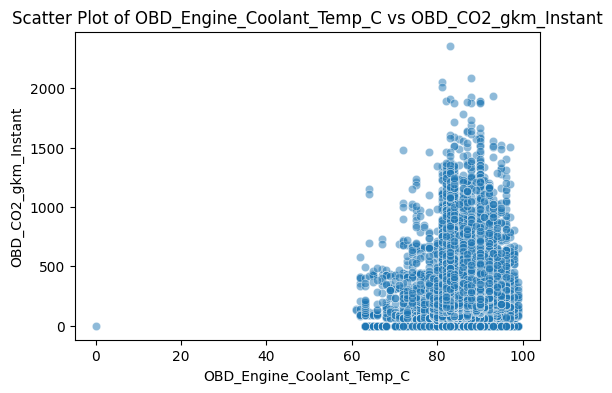

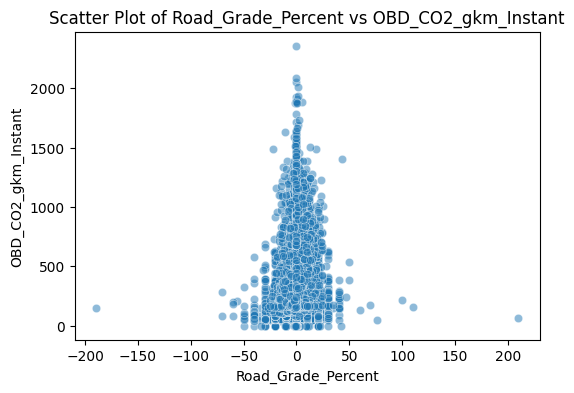

In [71]:
## Check non-linear relationships with CO2_Instant
import matplotlib.pyplot as plt
import seaborn as sns
for feature in top_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[feature], y=df["OBD_CO2_gkm_Instant"], alpha=0.5)
    plt.title(f'Scatter Plot of {feature} vs OBD_CO2_gkm_Instant')
    plt.xlabel(feature)
    plt.ylabel('OBD_CO2_gkm_Instant')
    plt.show()
